In [20]:
setwd("C:/Users/Sandeep Kushwaha/Desktop/phylum_plot/network")


In [21]:
# Load data
#setwd("C:/Users/Sandeep Kushwaha/Desktop/phylum_plot")
data <- read.table("net_data.txt", header = TRUE, sep = "\t", na.strings = "NA")

# Transpose and set column names from the first column
datap <- setNames(data.frame(t(data[,-1])), data[,1])

# Convert all values to numeric
datap[] <- lapply(datap, function(x) as.numeric(as.character(x)))

# Check
str(datap)


Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"


'data.frame':	7 obs. of  45 variables:
 $ Acinetobacter    : num  14.8 0 0 0 0 ...
 $ Actinomyces      : num  1.1 0 0 0 0 ...
 $ Anaplasma        : num  13.17 15.23 135.44 150.97 5.46 ...
 $ Achromobacter    : num  2.05 0 0 0 0 ...
 $ Bosea            : num  0.199 0 0 0 0 ...
 $ Blautia          : num  0 109.3 0 0 1.98 ...
 $ Bacillus         : num  7.3 499.3 0 2.38 2.24 ...
 $ Bradyrhizobiaceae: num  0.0662 0 0 0 0 ...
 $ Brevundimonas    : num  5.97 0 0 0 0 ...
 $ Campylobacter    : num  127.534 0 0.262 0.476 0 ...
 $ Caulobacter      : num  1.7 0 0 0 0 ...
 $ Chlamydia        : num  0 0 27.87 2.11 0 ...
 $ Chryseobacterium : num  14.1 0 0 0 0 ...
 $ Clostridium      : num  0.0882 0 11.3336 0 0 ...
 $ Comamonas        : num  53.8 0 0 0 0 ...
 $ Corynebacterium  : num  3.53 0 4.46 0 0 ...
 $ Cutibacterium    : num  3.029 0 0.824 0 0 ...
 $ Delftia          : num  13.6 0 0 0 0 ...
 $ Enterobacter     : num  29.65 170.94 1.45 0 0 ...
 $ Enterococcus     : num  39 0 87.21 0 6.55 ...
 $ E

In [22]:
# Spearman correlation
spearman_cor <- cor(datap, method = "spearman", use = "pairwise.complete.obs")

# Save full correlation matrix
write.table(signif(spearman_cor, 3), file = "raw_spearman_matrix.tsv", sep = "\t", quote = FALSE)


In [23]:
library(reshape2)

# Spearman correlation matrix on raw (non-transformed) data
spearman_cor <- cor(datap, method = "spearman", use = "pairwise.complete.obs")

# Save full matrix
write.table(signif(spearman_cor, 3), file = "raw_spearman_matrix.tsv", sep = "\t", quote = FALSE)

# Flatten upper triangle for network use
flat_spear <- melt(spearman_cor, varnames = c("Taxon1", "Taxon2"), value.name = "Spearman")
flat_spear <- subset(flat_spear, Taxon1 != Taxon2 & abs(Spearman) >= 0.6)

# Optional: remove duplicated edges (keep unique undirected edges)
flat_spear$pair <- apply(flat_spear[, 1:2], 1, function(x) paste(sort(x), collapse = "_"))
flat_spear <- flat_spear[!duplicated(flat_spear$pair), ]
flat_spear$pair <- NULL

# Save flattened edges
write.csv(flat_spear, "spearman_correlation_edges.csv", row.names = FALSE)


Warning message in alg_fun(graph):
"At vendor/cigraph/src/layout/large_graph.c:179 : LGL layout does not support disconnected graphs yet."
Warning message:
"ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


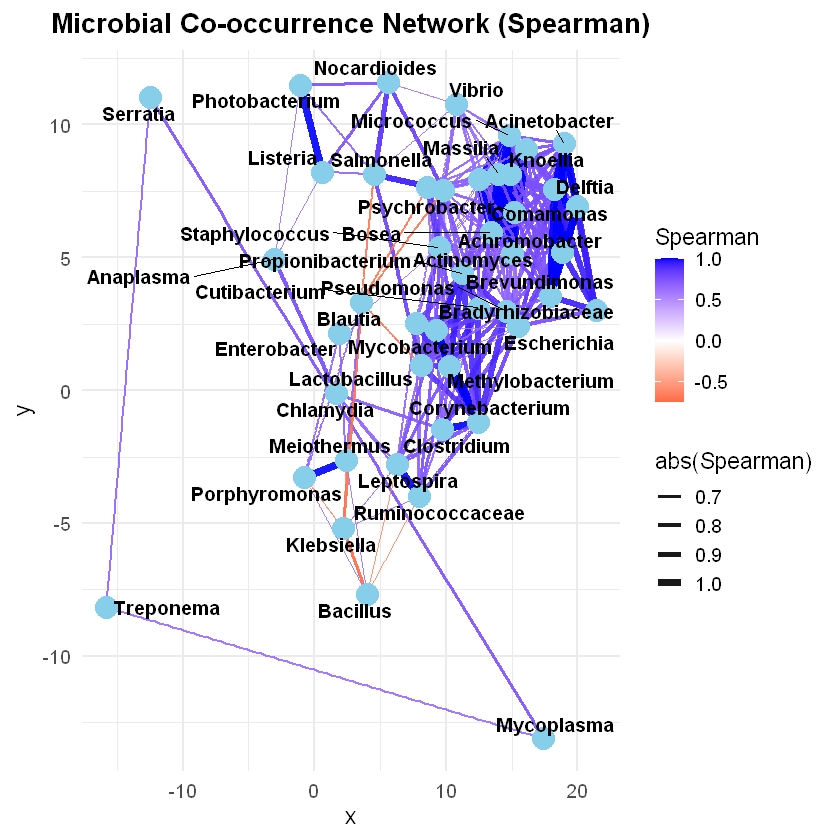

In [24]:
library(igraph)
library(ggraph)
library(tidygraph)
library(ggplot2)

# Create igraph object from filtered Spearman data
edges <- flat_spear[, c("Taxon1", "Taxon2", "Spearman")]
g <- graph_from_data_frame(edges, directed = FALSE)

# Plot with ggraph
p <- ggraph(as_tbl_graph(g), layout = "lgl") +
  geom_edge_link(aes(edge_width = abs(Spearman), edge_color = Spearman), alpha = 0.9) +
  geom_node_point(color = "skyblue", size = 6) +
  geom_node_text(aes(label = name), repel = TRUE, size = 4, fontface = "bold") +
  scale_edge_color_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0, name = "Spearman") +
  scale_edge_width(range = c(0.5, 2)) +
  theme_minimal(base_size = 14) +
  theme(
    panel.background = element_rect(fill = "white", color = NA),
    plot.background = element_rect(fill = "white", color = NA),
    legend.position = "right",
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold")
  ) +
  ggtitle("Microbial Co-occurrence Network (Spearman)")

# Save in high quality
ggsave("microbial_network.png", plot = p, width = 14, height = 8, dpi = 600, bg = "white")
ggsave("microbial_network.pdf", plot = p, width = 14, height = 8, bg = "white")
################################################### MY SCRIPT ##############################
plot(p)

In [25]:
##### SIR script
# Load necessary libraries
library(reshape2)
library(Hmisc)

#setwd("C:/Users/Sandeep Kushwaha/Desktop/phylum_plot")
data <- read.table("net_data.txt", header = TRUE, sep = "\t", na.strings = "NA")

# Transpose and set column names from the first column
datap <- setNames(data.frame(t(data[,-1])), data[,1])

# Convert all values to numeric
datap[] <- lapply(datap, function(x) as.numeric(as.character(x)))

# Check
str(datap)
############################
# 1. Compute Spearman correlation and p-values
res <- rcorr(as.matrix(datap), type = "spearman")

cor_matrix <- res$r
pval_matrix <- res$P

# 2. Flatten correlation and p-value matrices
flat_cor <- melt(cor_matrix, varnames = c("Taxon1", "Taxon2"), value.name = "Spearman")
flat_pval <- melt(pval_matrix, varnames = c("Taxon1", "Taxon2"), value.name = "p_value")

# 3. Merge into one data frame
flat <- merge(flat_cor, flat_pval, by = c("Taxon1", "Taxon2"))

# 4. Filter: remove self-correlations and keep only strong correlations
flat <- subset(flat, Taxon1 != Taxon2 & abs(Spearman) >= 0.6)

# 5. Remove duplicated undirected edges (A-B and B-A)
flat$pair <- apply(flat[, c("Taxon1", "Taxon2")], 1, function(x) paste(sort(x), collapse = "_"))
flat <- flat[!duplicated(flat$pair), ]
flat$pair <- NULL

# 6. Save for Cytoscape
write.csv(flat, "spearman_correlation_edges_with_pvalue.csv", row.names = FALSE)

# Optional: also save full matrices
write.table(signif(cor_matrix, 3), file = "full_spearman_matrix.tsv", sep = "\t", quote = FALSE)
write.table(signif(pval_matrix, 3), file = "spearman_pvalue_matrix.tsv", sep = "\t", quote = FALSE)


Warning message in FUN(X[[i]], ...):
"NAs introduced by coercion"


'data.frame':	7 obs. of  45 variables:
 $ Acinetobacter    : num  14.8 0 0 0 0 ...
 $ Actinomyces      : num  1.1 0 0 0 0 ...
 $ Anaplasma        : num  13.17 15.23 135.44 150.97 5.46 ...
 $ Achromobacter    : num  2.05 0 0 0 0 ...
 $ Bosea            : num  0.199 0 0 0 0 ...
 $ Blautia          : num  0 109.3 0 0 1.98 ...
 $ Bacillus         : num  7.3 499.3 0 2.38 2.24 ...
 $ Bradyrhizobiaceae: num  0.0662 0 0 0 0 ...
 $ Brevundimonas    : num  5.97 0 0 0 0 ...
 $ Campylobacter    : num  127.534 0 0.262 0.476 0 ...
 $ Caulobacter      : num  1.7 0 0 0 0 ...
 $ Chlamydia        : num  0 0 27.87 2.11 0 ...
 $ Chryseobacterium : num  14.1 0 0 0 0 ...
 $ Clostridium      : num  0.0882 0 11.3336 0 0 ...
 $ Comamonas        : num  53.8 0 0 0 0 ...
 $ Corynebacterium  : num  3.53 0 4.46 0 0 ...
 $ Cutibacterium    : num  3.029 0 0.824 0 0 ...
 $ Delftia          : num  13.6 0 0 0 0 ...
 $ Enterobacter     : num  29.65 170.94 1.45 0 0 ...
 $ Enterococcus     : num  39 0 87.21 0 6.55 ...
 $ E

In [26]:
# Load required libraries
library(igraph)
library(ggraph)
library(ggplot2)

# Build igraph object from correlation edges
g <- graph_from_data_frame(flat[, c("Taxon1", "Taxon2", "Spearman")], directed = FALSE)

# Set edge weights and colors
E(g)$weight <- abs(flat$Spearman)
E(g)$correlation <- flat$Spearman  # for coloring

# Optional: set node degree as size
V(g)$degree <- degree(g)

# Plot with ggraph
p <- ggraph(g, layout = "lgl") +
  geom_edge_link(aes(edge_width = weight, edge_color = correlation), alpha = 0.7) +
  geom_node_point(aes(size = degree), color = "skyblue") +
  geom_node_text(aes(label = name), repel = TRUE, size = 2.5) +
  scale_edge_color_gradient2(low = "red", mid = "white", high = "blue", midpoint = 0) +
  theme_void(base_size = 11) +
  ggtitle("Microbial Co-occurrence Network (Spearman ≥ 0.6)") +
  theme(
    plot.title = element_text(hjust = 0.3),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )
# Save plots
#ggsave("microbial_network_spearman.png", plot = p, width = 10, height = 8, dpi = 600, bg = "white")
#ggsave("microbial_network_spearman.pdf", plot = p, width = 10, height = 8, bg = "white")


Warning message in alg_fun(graph):
"At vendor/cigraph/src/layout/large_graph.c:179 : LGL layout does not support disconnected graphs yet."


Warning message in alg_fun(graph):
"At vendor/cigraph/src/layout/large_graph.c:179 : LGL layout does not support disconnected graphs yet."


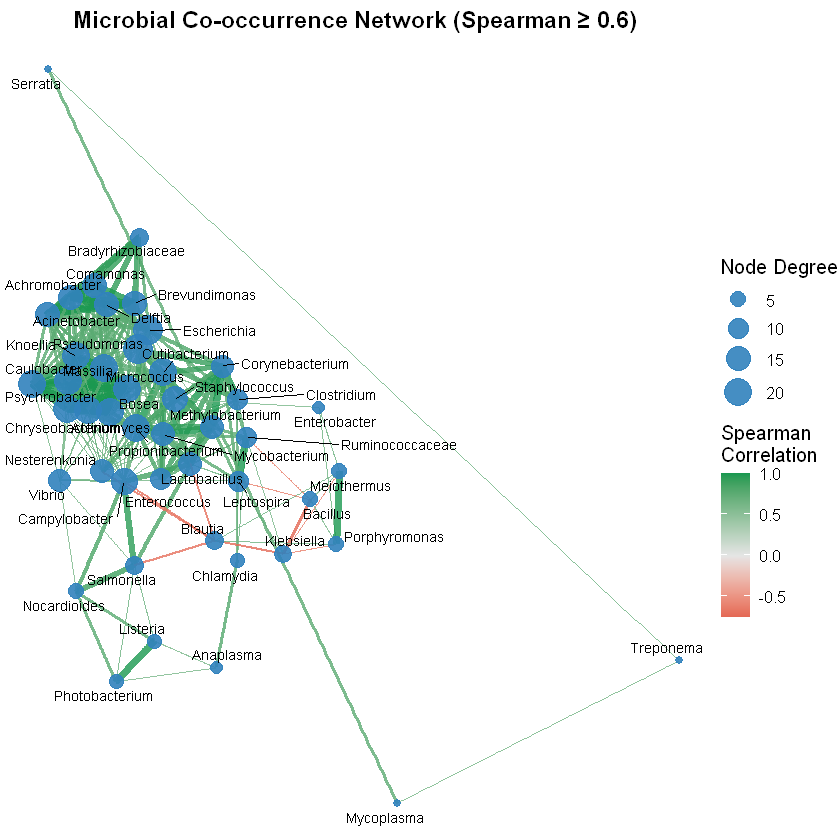

In [28]:
# Load required packages
library(ggraph)
library(igraph)
library(ggplot2)

# Example: Calculate degree if not present
V(g)$degree <- degree(g)

# Create the plot
p <- ggraph(g, layout = "lgl") + # to change layout of neywork
  # Edges
  geom_edge_link(aes(edge_width = weight, edge_color = correlation), alpha = 0.8) +
  scale_edge_color_gradient2(
    low = "#D73027",   # red for negative
    mid = "gray90",    # neutral
    high = "#1A9850",  # green/blue for positive
    midpoint = 0,
    name = "Spearman\nCorrelation"
  ) +
  
  # Nodes
  geom_node_point(aes(size = degree), color = "#3182bd", alpha = 0.9) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3, color = "black") +

  # Scales
  scale_size_continuous(range = c(2, 8), name = "Node Degree") +
  scale_edge_width(range = c(0.2, 2), guide = "none") +

  # Theme and title
  ggtitle("Microbial Co-occurrence Network (Spearman ≥ 0.6)") +
  theme_void(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    legend.position = "right",
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

# Display the plot
print(p)
ggsave("microbial_network_spearman2.png", plot = p, width = 10, height = 8, dpi = 600, bg = "white")



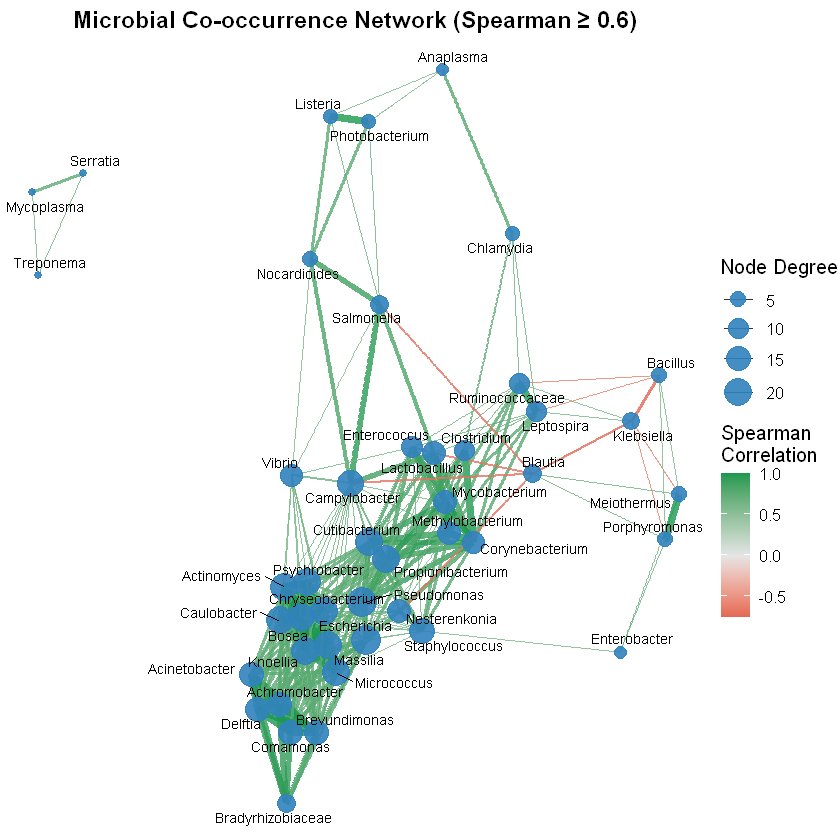

In [29]:
# Load required packages
library(ggraph)
library(igraph)
library(ggplot2)
library(tidygraph)

# Ensure graph has degree attribute
if (is.null(V(g)$degree)) {
  V(g)$degree <- degree(g)
}

# Convert to tidygraph format (optional but cleaner for ggraph)
tg <- as_tbl_graph(g)

# Improved Network Plot
p <- ggraph(tg, layout = "fr") +

  # Edges
  geom_edge_link(
    aes(edge_width = weight, edge_color = correlation),
    alpha = 0.8,
    show.legend = TRUE
  ) +
  scale_edge_color_gradient2(
    low = "#D73027",    # Negative correlations (red)
    mid = "gray90",     # Neutral (light gray)
    high = "#1A9850",   # Positive correlations (green)
    midpoint = 0,
    name = "Spearman\nCorrelation"
  ) +

  # Nodes
  geom_node_point(
    aes(size = degree),
    color = "#3182bd",
    alpha = 0.9
  ) +
  geom_node_text(
    aes(label = name),
    repel = TRUE,
    size = 3,
    color = "black"
  ) +

  # Scales and theme
  scale_size_continuous(range = c(2, 8), name = "Node Degree") +
  scale_edge_width(range = c(0.2, 2), guide = "none") +

  ggtitle("Microbial Co-occurrence Network (Spearman ≥ 0.6)") +
  theme_void(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    legend.position = "right",
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

# Show plot
print(p)

# Save high-resolution plot
ggsave("microbial_network_spearman.png", plot = p, width = 10, height = 8, dpi = 600, bg = "white")

# EXPORT: Save graph for Cytoscape (GraphML format)
#write_graph(g, file = "microbial_network.graphml", format = "graphml")


In [ ]:
################################################### STOP ##############################################

## FOR CYTOSCAPE ##
library(RCy3)
cytoscapePing()
library(igraph)
library(RCy3)
library(readr)

# ---- Ensure g is your igraph object with edge weights, correlations, and node degrees ----
# Add degree attribute to the nodes
V(g)$degree <- degree(g)

# ---- Create the network in Cytoscape via RCy3 ----
createNetworkFromIgraph(g, title = "Microbial Network", collection = "Spearman")

# ---- Export Edges Table ----
edges <- getTableColumns('edge', c("source", "target", "weight", "correlation"))
write_tsv(edges, "edges.tsv")

# ---- Export Nodes Table ----
nodes <- getTableColumns('node', c("name", "degree"))
write_tsv(nodes, "nodes.tsv")


You are connected to Cytoscape!

Loading data...


Applying default style...


Applying preferred layout...




networkSUID 
        128

In [ ]:
################################# TO MAKE SUBNETWORKS BASED ON THE CORRELATIONS #####################################################################
# Let's assume 'g' is your original igraph object
# Filter edges with Spearman correlation ≥ 0.8
edges_to_keep <- E(g)[correlation >= 0.9]
# Subgraph based on filtered edges
g_sub <- subgraph.edges(g, edges_to_keep, delete.vertices = TRUE)


Warning message:
"ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


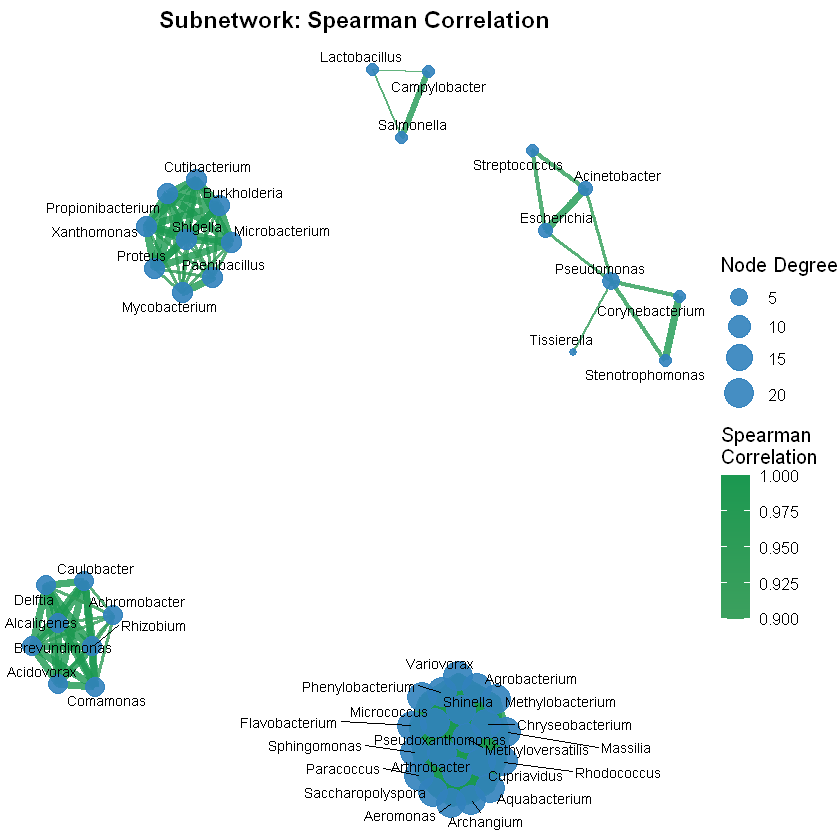

In [17]:
V(g_sub)$degree <- degree(g_sub)  # Update degrees for subgraph

p_sub <- ggraph(g_sub, layout = "fr") +
  geom_edge_link(aes(edge_width = weight, edge_color = correlation), alpha = 0.8) +
  scale_edge_color_gradient2(
    low = "#D73027", mid = "gray90", high = "#1A9850", midpoint = 0,
    name = "Spearman\nCorrelation"
  ) +
  geom_node_point(aes(size = degree), color = "#3182bd", alpha = 0.9) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3, color = "black") +
  scale_size_continuous(range = c(2, 8), name = "Node Degree") +
  scale_edge_width(range = c(0.2, 2), guide = "none") +
  ggtitle("Subnetwork: Spearman Correlation") +
  theme_void(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    legend.position = "right",
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

print(p_sub)
